In [1]:
def bisect(func, low, high, tolerance=1e-8):
    # bisection algorithm: look for x near such that func(x)=0
    # The bisection stops when the change in x becomes small, not when
    # the change in func(x) becomes small
    fuLo, fuHi = func(low), func(high)
    assert fuLo * fuHi < 0
    for i in range(54):
        midpoint = 0.5 * (low + high)
        if 0 < fuLo * func(midpoint):
            low = midpoint
        else:
            high = midpoint
        if abs(high - low) <= tolerance:
            break
    return midpoint

In [2]:
import numpy as np
from math import floor, ceil # Import ceil from the math module
import matplotlib.pyplot as plt

class pixel:
  # Corrected __init__ method name
  def __init__(self, nBins=100,
              horResolution = 100, verResolution = None,
              edgeResolution = None, verDiff = 1, method = "random"):
    # horResolution and verResolution are used for the simulation at corners.

    self.nBins = ceil(nBins)
    self.horResolution = ceil(horResolution)

    # Ensure verResolution is always set
    # it might be good if the vertical resolution is different from
    # the horizontal resolution
    if (verResolution is None):
      self.verResolution = ceil(horResolution + verDiff)
    else:
      self.verResolution = ceil(verResolution)

    # use random values at corners or try numerical integration?
    if ("random" == method or "even" == method):
      self.method = method
    else:
      raise ValueError ("method must be 'random' or 'even'")

  # calculate the effects of corners and edges for a charge cloud
  # of radius 1. Scaling to realistic values will be done later.
    self.unscaledCorners()
    self.unscaledEdgesByBisection()

  def edgepiece(self, d):
  # calculate the area of a circle that goes over an edge,
  # if the center is at a distance d from the edge,
  # for a circle of radius 1.
    if (1< d):
      return 0
    else:
      alfa = np.arccos ( d)
      # sqrt (r² -d²)
      return alfa - (d*np.sqrt(1-d**2))

  def cornerpiece(self, x,y):
  # calculate the area of the part of  a circle that
  # has x<0, y<0, if the center is at coordinates (x,y)
  # for a circle of radius 1.
    if (1 < x**2 + y**2):
      return 0
    else:
      alfaX = np.arcsin(y)
      alfaY = np.arccos(x)
      return (0.5 * (alfaY-alfaX)+x*y
              - 0.5 * x*np.sqrt(1-x**2) - 0.5 * y * np.sqrt(1-y**2))

  def defineBins(self):
  # the limits of the areas
    # max area is pi * r² = pi
    self.bins = np.linspace(0,np.pi,self.nBins+1)

  def unscaledEdgesByBisection(self):
  # calculate the probability that a the area over the edge is between
  # certain limits, for a circle of radius 1,
  # whose center is at a random distance (less than 1) from an edge,

    self.defineBins()
    # the corresponding distances from the edge
    dValues = np.zeros(self.nBins)

    # probabilities that the part over the edge is within limits
    self.proba_overEdges = np.zeros(self.nBins)
    # probabilities that the main part is within limits
    self.proba_insideEdges = np.zeros(self.nBins)

    print( "self.nBins = "+ str(self.nBins))

    # the area over the edge <= pi/2
    # the main area >=pi/2
    # So iterate over half of the bins. Round upward if nBins is odd
    for i in range(ceil(self.nBins/2-1), 0, -1):
      #note: if nBins is odd, the first value for d will be half as big,
      # and [i]=[-i-1] so dValue will be added to a bin of overEdges and insideEdges
      dValues[i] = bisect(lambda x: self.edgepiece(x)-self.bins[i], 0, 1)
      # probability equals the change in distance
      self.proba_overEdges[i] = dValues[i]-dValues[i+1]
      # add probabilities for the remaining part.
      # dValues [-i-1] = dValues[i]
      # self.proba_insideEdges[-i-1] = dValues[-i-1]-dValues[-(i+1)-1]
      self.proba_insideEdges[-i-1] = self.proba_overEdges[i]

    # i=0, dValues[0] = 1
    self.proba_overEdges[0] = 1-dValues[1]
    self.proba_insideEdges[-1] += self.proba_overEdges[0]

    return

  def unscaledCorners(self):
  # calculate the probabilities that a the area over the edges is between
  # certain limits, for a circle of radius 1,
  # whose center is at a random distance (less than 1) from 2 edges of a corner

    self.defineBins() # same as for unscaledEdges()
    # probalities
    # - for the area that is still on the pixel
    # - for the area that is spilled on the opposite corner
    # - for the area that is spilled over 1 edge
    self.proba_insideCorner      = np.zeros(self.nBins)
    self.proba_overCornerEdges   = np.zeros(self.nBins)
    self.proba_overCorners       = np.zeros(self.nBins)
    nOverCorners = 0

    # hits will first be counted, then converted to probabilities
    for i in range(self.horResolution):
      corners = []
      edges = []
      insides = []
      if ("random"== self.method):
        xArr = np.random.uniform(0.,1,self.verResolution)
        yArr = np.random.uniform(0.,1,self.verResolution)
      else:
        # the use of evenly space values can lead to artifacts!
        # these artifacts are mitigated if horResolution !+verResolution
        yArr = np.linspace(0.5/self.verResolution, 1-0.5/self.verResolution
                           ,self.verResolution)
        xArr = np.ones(self.verResolution)*(i+0.5)/self.horResolution

      for j in range(self.verResolution):
        x = xArr[j]
        y = yArr[j]

        corner = self.cornerpiece(x,y)
        edgeX = self.edgepiece(x)  - corner
        edgeY = self.edgepiece(y)  - corner

        if (corner > 0): # has a probability of pi/4 (quarter circle)
          nOverCorners += 1
          corners.append(corner)
        # for symmetry reasons, spills over the x-axis are counted
        # in the same way as spills over the y-axis
        if (edgeX > 0): # should always be true
          edges.append(edgeX)
        if (edgeY > 0): # should always be true
          edges.append(edgeY)

        insides.append(np.pi - corner - edgeX - edgeY)

      # regularly summarize results in bins
      countCorners, foo = np.histogram(corners, range=(0,np.pi), bins=self.nBins)
      countEdges, foo = np.histogram(edges, range=(0,np.pi), bins=self.nBins)
      countInsides, foo = np.histogram(insides, range=(0,np.pi), bins=self.nBins)
      self.proba_overCorners += countCorners
      self.proba_overCornerEdges += countEdges
      self.proba_insideCorner += countInsides

    # Convert to probabilities
    total_counts = self.horResolution * self.verResolution
    self.proba_overCorners       = self.proba_overCorners / total_counts
    self.proba_overCornerEdges   = self.proba_overCornerEdges / total_counts
    self.proba_insideCorner = self.proba_insideCorner / total_counts

    # a small check on the distribution of samples
    print ("total number of corners: " + str(nOverCorners/(self.verResolution*
                            self.horResolution))) # should approach pi.
    print ("PI /4  " + str(np.pi /4 ))
    return corners, edges, insides

  def scaledImpact(self, maxE = 60, cutoffE = 20, pixelWidth = 200, radius = 100, type ="center"):
    if (pixelWidth < 2*radius):
      raise ValueError ("the simulation is not valid if pixelWidth < 2 * radius") # Corrected raise

    if ("corner"== type):
      nCorners = 1
      nEdges = 2
    elif ("edge"== type):
      nCorners = 2
      nEdges = 3
    elif ("center"== type):
      nCorners = 4
      nEdges = 4
    else:
      raise ValueError ("type must be center, edge or corner") # Corrected raise

    # self.proba_overEdges and elf.proba_insideEdges
    # were populated by unscaledEdges(..)
    # self.proba_insideCorner, self.proba_overCornerEdges, self.proba_overCorners
    # are populated by unscaledCorners(..)

    # add probabilities:
    # - of areas that remain on the pixel
    #   (insideCorner, insideEdges)
    # - of detections due to impacts on neighbouring pixels
    #   (overEdges, overCornerEdges)
    #  - of detections due to impacts on an opposite corner of a cell
    #    (overCorner)
    # Probabilities are multiplied by their area (r² for each corner,
    # r * width for an edge) and divided by the total area (width²)
    result = (( 4 * self.proba_insideCorner +
                nEdges * self.proba_overCornerEdges +
                nCorners * self.proba_overCorners)
                * ((radius/pixelWidth) **2)  +
                (nEdges * self.proba_overEdges
                + 4 * self.proba_insideEdges)
                  * (radius/pixelWidth) * (1 - 2 * radius/pixelWidth))
    # impacts count for 100% in the center area (leave out edges and corners)
    result[self.nBins-1] += (1 - 2 * radius/pixelWidth)**2

    # scale to the correct energy
    self.bins = np.linspace(0,maxE,self.nBins+1)

    # estimate the total energy (using a correction because the average energy
    # in a bin is lower than its upper limit)
    print ( "total energy: " + str(np.inner(result, self.bins[1:])
              -maxE/2/self.bins.size))

    # remove lowest energies
    cutoffIndex = floor(self.nBins*cutoffE/maxE+0.5)
    result = result[cutoffIndex:]
    print ( "total energy above " + str(cutoffE)+": "
                + str(np.inner(result , self.bins[cutoffIndex+1:])
              -maxE/2/self.bins.size) )
    return result, self.bins[cutoffIndex:]

  def graphTitle(self):
    if (self.method == "even"):
      result = ('resolution '+str(self.horResolution)+"x"
          + str(self.verResolution))
    if (self.method == "random"):
      result = (str(self.horResolution*self.verResolution)+
                    " random shots in corners")
    return result + ", max "+ str(self.bins[-1]) + " keV "

  # the output of scaledImpact is input for this method
  def makePlot(self, hist_counts, bin_edges, titel = None):
    print("Histogram Counts (bins):")
    print(sum(hist_counts))
    print("\nBin Edges ( "+ str(myPixel.nBins)+ " bins):")

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the histogram using the counts and bin edges
    ax.hist(bin_edges[:-1], bin_edges, weights=hist_counts)

    # Add labels and title
    ax.set_xlabel('Impact Value')
    ax.set_ylabel('probability')
    if (None== titel):
      ax.set_title(self.graphTitle())
    else:
      ax.set_title(titel)

    # Display the plot
    plt.show()

    return plt

  def selectSeries(self, pixelWidth = 200, radius = 100, type =None,
             nInsideCorners = 0, nCornerEdges = 0, nOverCorners = 0,
                        nOverEdges = 0, nInsideEdges = 0,
                        useCenter = 0):
  # allows more choices than calculateImpacts, for debugging and analysis
    print("ninsidecorners = "+str(nInsideCorners))
    print("nCornerEdges = "+str(nCornerEdges))
    print("nOverCorners = "+str(nOverCorners))
    print("nOverEdges = "+str(nOverEdges))
    print("nInsideEdges = "+str(nInsideEdges))
    if ("corner"== type):
      nInsideCorners, nCornerEdges, nOverCorners = 4, 2, 1
      nOverEdges, nInsideEdges = 0, 0
      useCenter = 1
    elif ("edge"== type):
      nInsideCorners, nCornerEdges, nOverCorners = 4, 3, 2
      nOverEdges, nInsideEdges = 3,4
      useCenter = 1
    elif ("center"== type):
      nInsideCorners, nCornerEdges, nOverCorners = 4, 4, 4
      nOverEdges, nInsideEdges = 4,4
      useCenter = 1
    elif (None == type):
      raise ValueError ("set type to 'other' and enter parameters")

    series =[]
    labels = []

    if (4 == nInsideEdges):
      series.append(nInsideEdges * self.proba_insideEdges
                    * (radius/pixelWidth) * (1 - 2 * radius/pixelWidth))
      labels.append("remainder at edge")
    if (0 != nOverEdges):
      series.append(nOverEdges * self.proba_overEdges
                    * (radius/pixelWidth) * (1 - 2 * radius/pixelWidth))
      labels.append("spills from neighbour at edge")
    if (4 == nInsideCorners):
      series.append(nInsideCorners * self.proba_insideCorner
                    * ((radius/pixelWidth) **2))
      labels.append("remainder at corner")
    if (0 != nCornerEdges):
      series.append(nCornerEdges * self.proba_overCornerEdges
                    * ((radius/pixelWidth) **2))
      labels.append("spills form neighbour near corner")
    if (0 != nOverCorners):
      series.append(nOverCorners * self.proba_overCorners
                    * ((radius/pixelWidth) **2))
      labels.append("spills from neighbour at cornertip")
    if (1 == useCenter):
      y = np.zeros(self.proba_insideEdges.size)
      y[self.proba_insideEdges.size-1] = \
      (1 - 2 * radius/pixelWidth)**2
      # * (radius/pixelWidth) NO! leave this factor out
      series.append(y)
      labels.append("in the center")

    if 0==len(series):
      raise ValueError ("set type or enter parameters")

    return series, labels

  def makeStackedHistograms(self, maxE = 1, pixelWidth = 200, radius = 100, type =None,
             nInsideCorners = 0, nCornerEdges = 0, nOverCorners = 0,
                        nOverEdges = 0, nInsideEdges = 0,
                        useCenter = 0, titel = None):
    # Create a figure and an axes object

    series, labels = self.selectSeries(pixelWidth, radius, type,
             nInsideCorners, nCornerEdges, nOverCorners,
                        nOverEdges, nInsideEdges ,
                        useCenter)

    x = []
    for i in range(len(series)):
      x.append(self.bins[:-1])#*maxE/np.pi) # don't scale: ax.hist can't handle it.

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(x, weights =series, bins = self.bins, histtype='stepfilled', stacked=True,
            label = labels)

    # Add labels and title
    ax.set_xlabel('detected impact')
    ax.set_ylabel('probability')
    if (None == titel):
      ax.set_title(self.graphTitle())
    else:
      ax.set_title(titel)

    ax.legend(loc = 'upper center')

    # Display the plot
    plt.show()

    return plt

  def makeStackedPlot(self, maxE = 1, pixelWidth = 200, radius = 100, type =None,
             nInsideCorners = 0, nCornerEdges = 0, nOverCorners = 0,
                        nOverEdges = 0, nInsideEdges = 0,
                        useCenter = 0):
    # the graphs are not as beautiful as makeStackedHistograms make them
    # but makeStackedPlot allows scaling of the x-axis.

    series, labels = self.selectSeries(pixelWidth, radius, type,
             nInsideCorners, nCornerEdges, nOverCorners,
                        nOverEdges, nInsideEdges,
                        useCenter)

    x = self.bins[1:] / np.pi * maxE

    fig, ax = plt.subplots(figsize=(10, 6))

    y = np.vstack(series)

    ax.stackplot(x, y, labels=labels)

    # Add labels and title
    ax.set_xlabel('detected impact')
    ax.set_ylabel('probability')
    ax.set_title('Histogram of Impacts for an energy of '+str(maxE)+
                 ', pixelsize = '+str(pixelWidth/radius)+" R")
    ax.legend(loc = 'upper center')
    # Display the plot

    plt.show()

    return plt

# myPixel = pixel(edgeFactor=200, horResolution=500, verResolution = 500, nBins = 100)


total number of corners: 1.0
PI /4  0.7853981633974483
self.nBins = 200
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


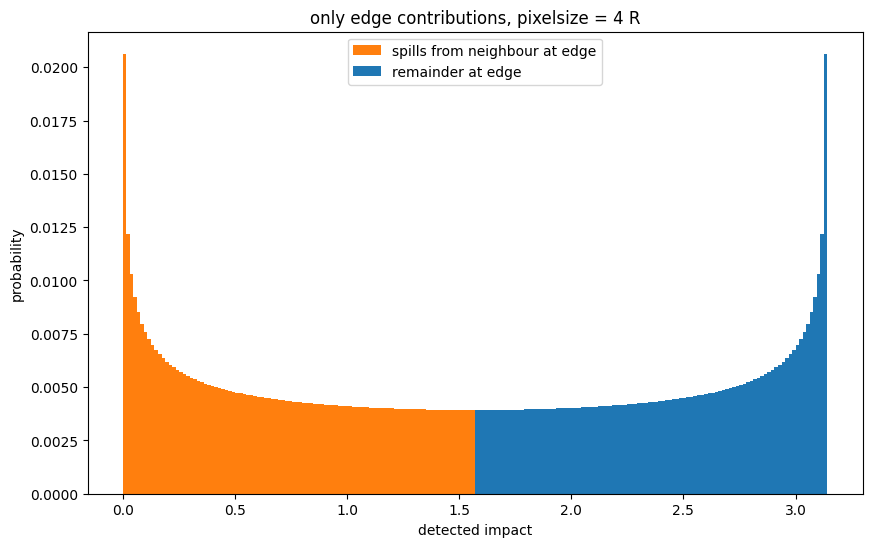

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [3]:

myPixel = pixel(horResolution=1, verResolution = 1, nBins = 200)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=400, type = "",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "only edge contributions, pixelsize = 4 R")


total number of corners: 0.786
PI /4  0.7853981633974483
self.nBins = 200
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


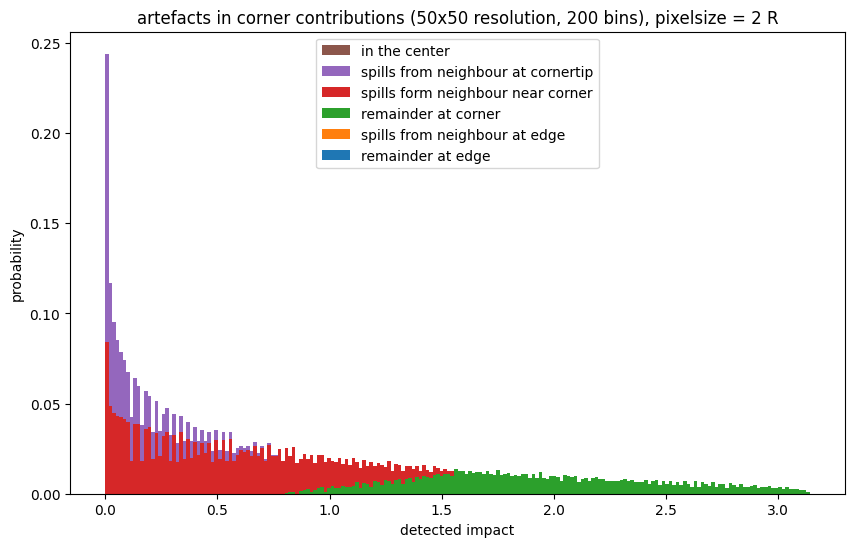

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [4]:
myPixel = pixel(method="even", horResolution=50, verResolution = 50, nBins = 200)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=200, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "artefacts in corner contributions (50x50 resolution, 200 bins), pixelsize = 2 R")


total number of corners: 0.7996
PI /4  0.7853981633974483
self.nBins = 200
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


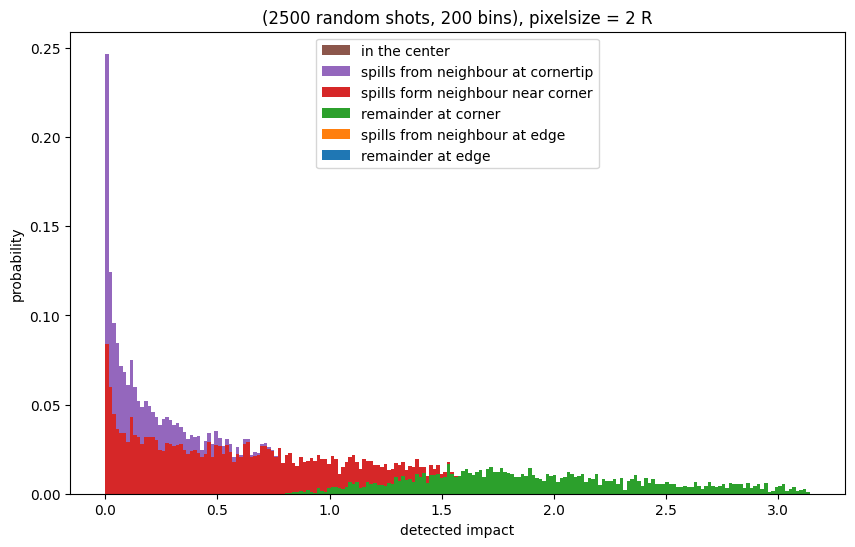

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [5]:
myPixel = pixel(horResolution=50, verResolution = 50, nBins = 200)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=200, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "(2500 random shots, 200 bins), pixelsize = 2 R")


total number of corners: 0.786012
PI /4  0.7853981633974483
self.nBins = 200
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


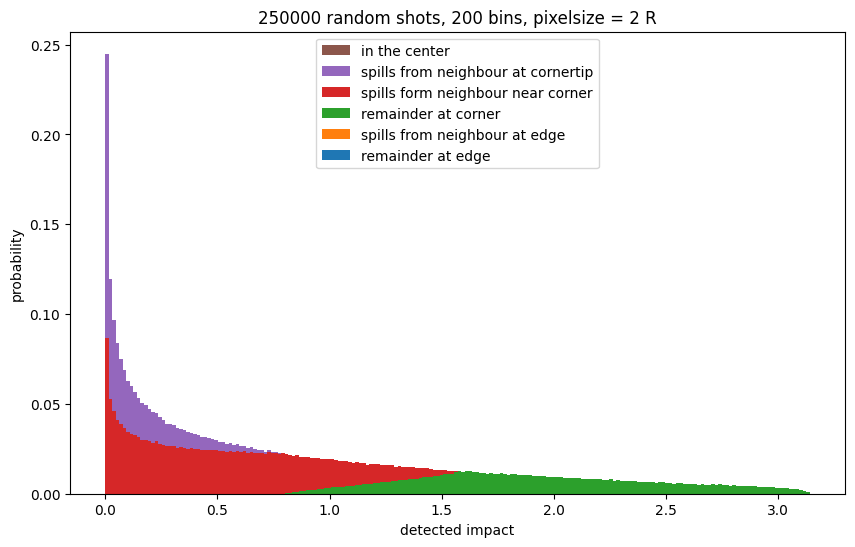

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [6]:
myPixel = pixel(method="random", horResolution=500, verResolution = 500, nBins = 200)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=200, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0
                      , titel = "250000 random shots, 200 bins, pixelsize = 2 R")


total number of corners: 0.7853
PI /4  0.7853981633974483
self.nBins = 60
ninsidecorners = 0
nCornerEdges = 0
nOverCorners = 0
nOverEdges = 4
nInsideEdges = 4


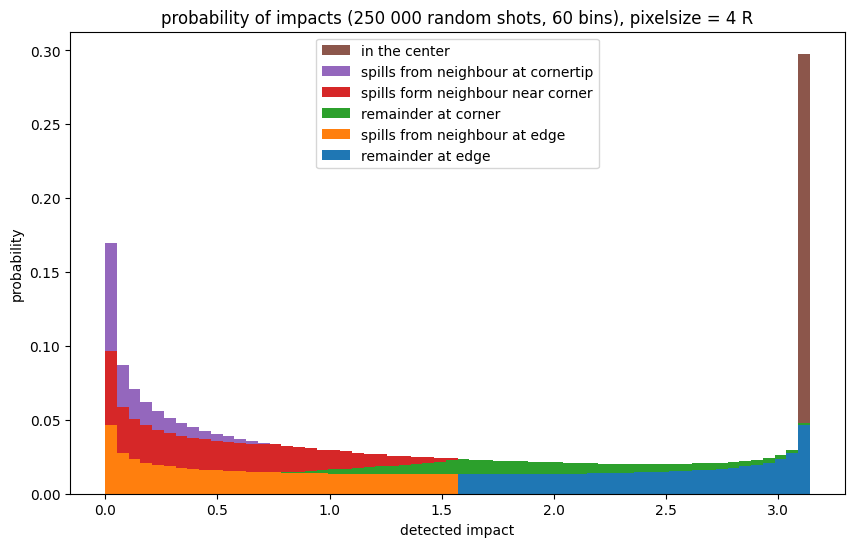

ninsidecorners = 4
nCornerEdges = 4
nOverCorners = 4
nOverEdges = 4
nInsideEdges = 4


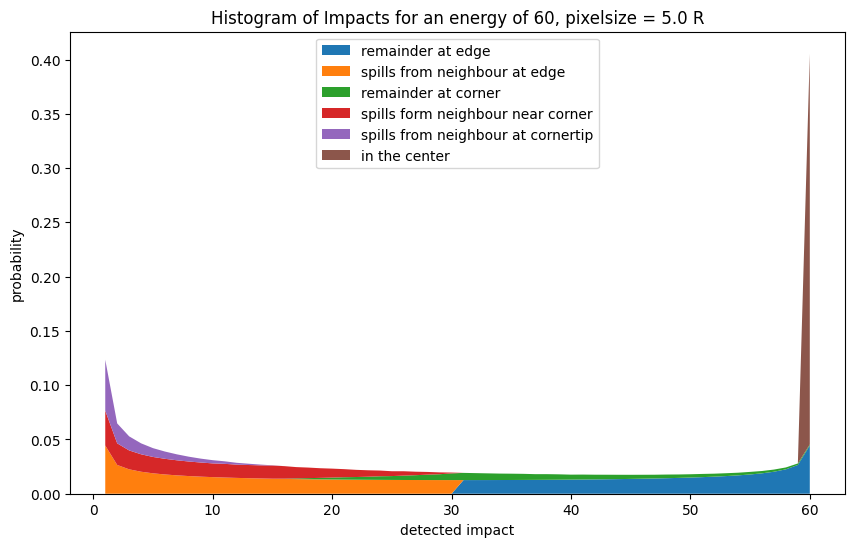

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [7]:
myPixel = pixel(horResolution=500, verResolution = 500, nBins = 60)

myPixel.makeStackedHistograms(maxE=60,pixelWidth=400, type = "center",
                              nInsideCorners = 0, nCornerEdges =0 , nOverCorners = 0,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0 ,
                        titel = "probability of impacts (250 000 random shots, 60 bins), pixelsize = 4 R")


myPixel.makeStackedPlot(maxE= 60,pixelWidth=500, type = "center",
                              nInsideCorners = 4, nCornerEdges =4 , nOverCorners = 4,
                        nOverEdges = 4, nInsideEdges = 4,
                        useCenter = 0)
                        #titel = "probability of impacts (250 000 random shots, 150 bins), pixelsize = 4 R")

total number of corners: 0.78561
PI /4  0.7853981633974483
self.nBins = 60
total energy: 61.49200372131148
total energy above 20: 42.62813872131148
Histogram Counts (bins):
1.2295530000000001

Bin Edges ( 60 bins):


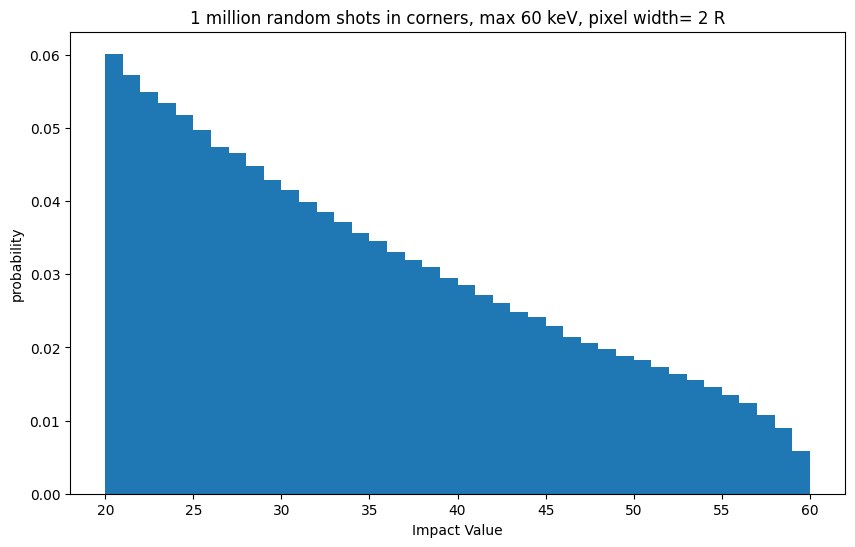

total energy: 61.09783320131148
total energy above 20: 46.9460527767227
Histogram Counts (bins):
1.2316921883372502

Bin Edges ( 60 bins):


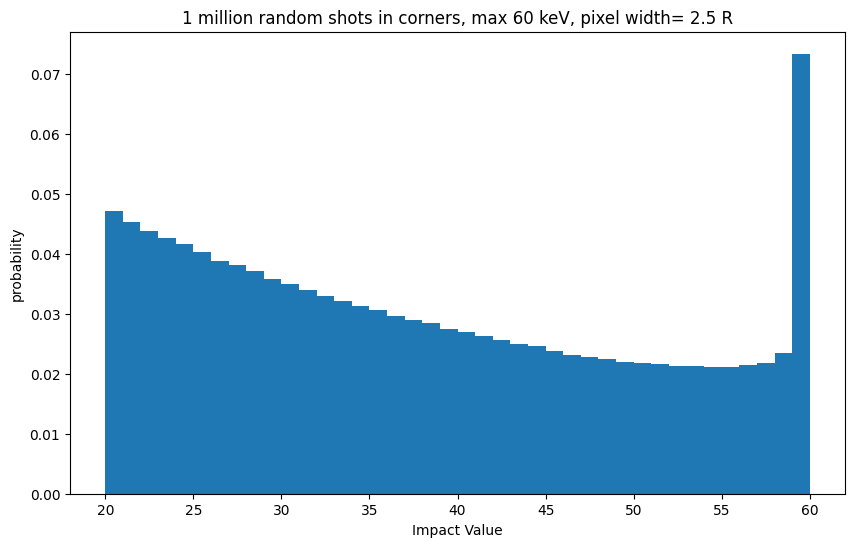

total energy: 60.504148471311474
total energy above 20: 52.53989030789151
Histogram Counts (bins):
1.1898542942769528

Bin Edges ( 60 bins):


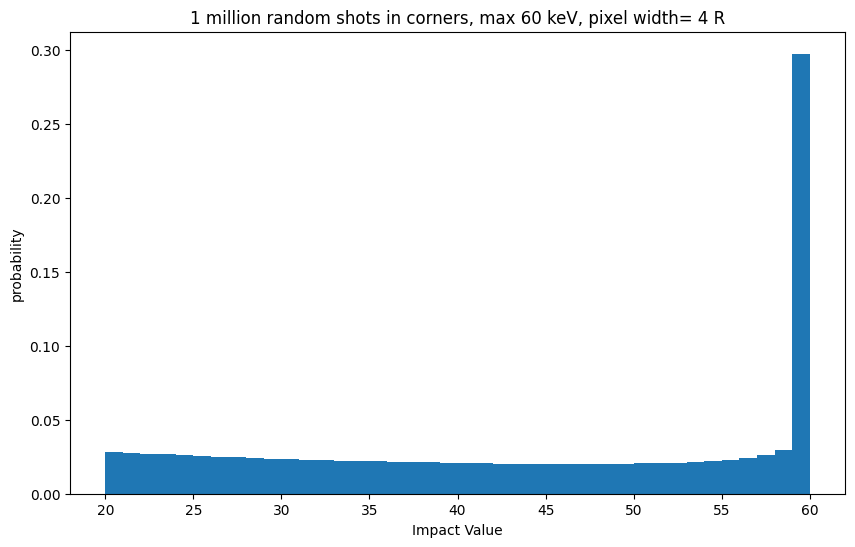

total energy: 60.30560584131148
total energy above 20: 54.16902720442831
Histogram Counts (bins):
1.1638958825058747

Bin Edges ( 60 bins):


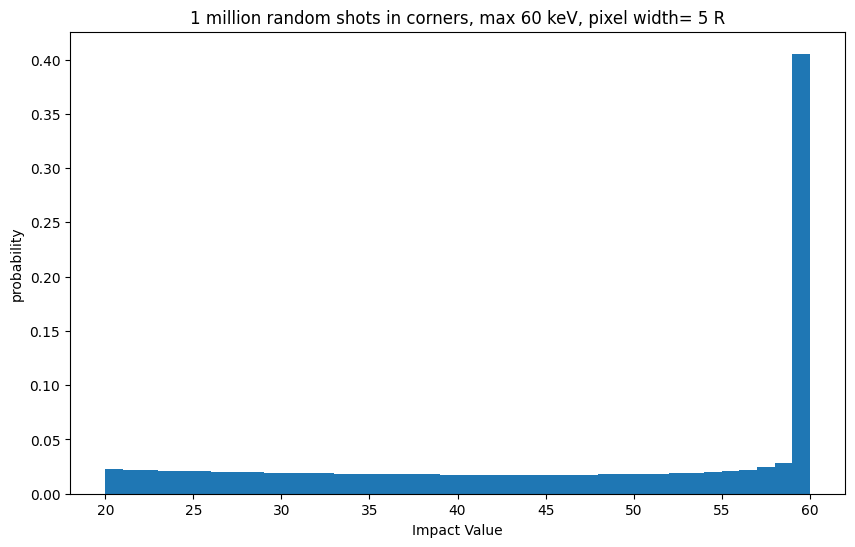

total energy: 59.907549001311494
total energy above 20: 57.07408757672271
Histogram Counts (bins):
1.09396038833725

Bin Edges ( 60 bins):


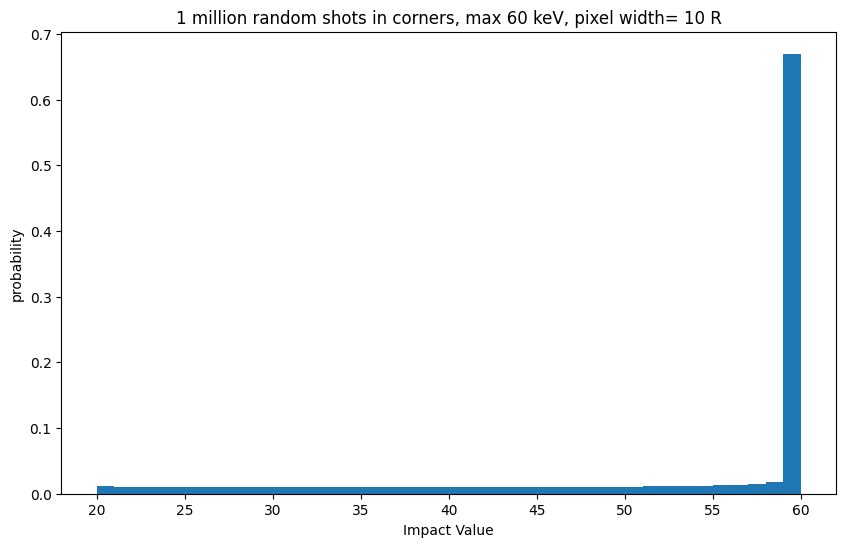

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [8]:

myPixel = pixel(method= "random", horResolution=1000,verResolution = 1000, nBins = 60)

hist_counts , bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=200, type = "center")
myPixel.makePlot(hist_counts, bin_edges , "1 million random shots in corners, max 60 keV, pixel width= 2 R")

hist_counts , bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=250, type = "center")
myPixel.makePlot(hist_counts, bin_edges , "1 million random shots in corners, max 60 keV, pixel width= 2.5 R")

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=400, type = "center")
myPixel.makePlot(hist_counts, bin_edges , "1 million random shots in corners, max 60 keV, pixel width= 4 R")

hist_counts, bin_edges = myPixel.scaledImpact(maxE=60,pixelWidth=500, type = "center")
myPixel.makePlot(hist_counts, bin_edges , "1 million random shots in corners, max 60 keV, pixel width= 5 R")

hist_counts, bin_edges  = myPixel.scaledImpact(maxE=60,pixelWidth=1000, type = "center")
myPixel.makePlot(hist_counts, bin_edges , "1 million random shots in corners, max 60 keV, pixel width= 10 R")
